In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
url = '/content/drive/MyDrive/SoftCom_Lab/Assignment_2/'

In [ ]:
dataset_A = url + 'dataset_2_image.zip'
with ZipFile(dataset_A, 'r') as zip:
  zip.extractall()

In [ ]:
PATH = '/content/'
train_data_labels = pd.read_csv('/content/csv/updatetrain.csv', usecols = ['filename', 'digit'])
test_data_labels = pd.read_csv('/content/csv/updatetest.csv', usecols = ['filename', 'digit'])
train_data_labels.head()


,filename,digit
0,0.jpg,9
1,1.jpg,0
2,2.jpg,0
3,3.jpg,3
4,4.jpg,0


In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(train_data_labels, '/content/train', train_transform)
test_data = Dataset(test_data_labels, '/content/test_28', test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  60000


# **Base Parameters**

In [ ]:
batch_size = 20
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

6


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:2400
Test dataloader:600


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.softmax_1 = nn.Softmax(dim=0)
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.softmax_2 = nn.Softmax(dim=0)
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.softmax_3 = nn.Softmax(dim=0)
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.softmax_4 = nn.Softmax(dim=0)
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.softmax_5 = nn.Softmax(dim=0)
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.softmax_6 = nn.Softmax(dim=0)
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.softmax_1(out)
        
        out  = self.linear_2(out)
        out = self.softmax_2(out)
 
        out  = self.linear_3(out)
        out = self.softmax_3(out)
 
        out  = self.linear_4(out)
        out = self.softmax_4(out)
 
        out  = self.linear_5(out)
        out = self.softmax_5(out)
 
        out  = self.linear_6(out)
        out = self.softmax_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (softmax_1): Softmax(dim=0)
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (softmax_2): Softmax(dim=0)
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (softmax_3): Softmax(dim=0)
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (softmax_4): Softmax(dim=0)
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (softmax_5): Softmax(dim=0)
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (softmax_6): Softmax(dim=0)
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 2.020113468170166. Accuracy: 18.5
Iteration: 1000. Loss: 1.8269275426864624. Accuracy: 37.15833333333333
Iteration: 1500. Loss: 1.4486260414123535. Accuracy: 44.80833333333333
Iteration: 2000. Loss: 1.2257587909698486. Accuracy: 50.11666666666667
Epoch:  2
Iteration: 2500. Loss: 0.8166800737380981. Accuracy: 54.233333333333334
Iteration: 3000. Loss: 1.122248888015747. Accuracy: 56.31666666666667
Iteration: 3500. Loss: 1.6225627660751343. Accuracy: 61.625
Iteration: 4000. Loss: 0.8825678825378418. Accuracy: 63.15833333333333
Iteration: 4500. Loss: 0.7649689316749573. Accuracy: 62.108333333333334
Epoch:  3
Iteration: 5000. Loss: 1.0489497184753418. Accuracy: 66.44166666666666
Iteration: 5500. Loss: 1.0851081609725952. Accuracy: 66.15833333333333
Iteration: 6000. Loss: 0.8802288174629211. Accuracy: 67.26666666666667
Iteration: 6500. Loss: 0.7389585375785828. Accuracy: 65.925
Iteration: 7000. Loss: 1.0447906255722046. Accuracy: 67.09166666666667
Epoch:  4
It

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/SoftCom_Lab/Assignment_2/Models/model_base1.pkl')

[2.020113468170166, 1.8269275426864624, 1.4486260414123535, 1.2257587909698486, 0.8166800737380981, 1.122248888015747, 1.6225627660751343, 0.8825678825378418, 0.7649689316749573, 1.0489497184753418, 1.0851081609725952, 0.8802288174629211, 0.7389585375785828, 1.0447906255722046, 1.5656284093856812, 0.7129935622215271, 0.8803591728210449, 1.4615792036056519, 0.8861069679260254, 1.2492966651916504, 1.3675627708435059, 1.2797815799713135, 0.6150416731834412, 1.4465078115463257, 1.4125735759735107, 0.886880099773407, 1.1197565793991089, 1.3553961515426636]


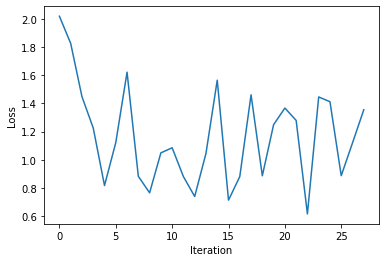

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()